In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1 前言


处置效应：投资者急于卖出盈利的股票，而不愿意卖出亏损的股票；损失股票的持有时间比收益股票的持有时间长；当股票的价格接近投资者的购买价格的时候，投资者效用会发生剧烈改变。

本文从筹码分布的角度来挖掘由于处置效应导致的定价错误，从而得到能获取超额收益的alpha因子。

# 2 筹码分布的计算
我们希望量化股票筹码的盈利状态和集中程度，为此定义如下两个指标：*相对资本收益*和*调整换手率*。

给定任意一支股票，其在t日成交均价为$P_{t}$，t-n日成交均价为$P_{t-n}$。以t日为目标日计算筹码分布，则t-n日（1≤n≤60）的相对资本收益为：
$$RC_{t-n}=\frac{P_{t}-P_{t-n}}{P_{t}}$$

t日换手率为$TR_{t}$，t-n日换手率为$TR_{t-n}$。以t日为目标日计算t-n日的调整换手率为：
$$ATR_{t-n}=TR_{t-n}(1-TR_{t-n+1})(1-TR_{t-n+2})(1-TR_{t})$$

根据相对资本收益及调整换手率，可以构建出筹码分布的均值、方差两个代理变量：
$$ARC_{t}=\frac{\sum_{n=1}^{60}ATR_{t-n}RC_{t-n}}{\sum_{n=1}^{60}ATR_{t-n}}$$
$$VRC_{t}=\frac{60\sum_{n=1}^{60}ATR_{t-n}(RC_{t-n}-ARC_{t})^{2}}{59\sum_{n=1}^{60}ATR_{t-n}}$$

这两个变量的直观含义如下：
ARC>0代表筹码处于平均盈利状态，ARC<0代表筹码处于平均亏损状态；
VRC恒大于0，且VRC越大代表筹码盈亏状态越分散，VRC越小代表筹码盈亏状态越集中。

计算时间：2010年10月-2020年10月  
在每个月的最后一个交易日对全部A股计算ARC、SRC

In [12]:
aprice = pd.read_csv('daily_ap.csv', index_col=0)  # daily average price
turnover = pd.read_csv('turnover.csv', index_col=0)  # daily turnover
monthly_date = pd.read_csv('trade_date.csv')  
monthly_date = monthly_date[(monthly_date['trade_date'] >= '2010-10-1') & (monthly_date['trade_date'] < '2020-11-1')]['trade_date'].tolist()   # monthly trade date

In [63]:
def ATR_RC(month, n=60):
    '''
    Compute ATR and RC for one cross-section.
    '''
    pos = list(aprice.columns).index(month)
    ap_i = aprice.iloc[:, (pos-n):(pos+1)]
    to_i = turnover.iloc[:, (pos-n):(pos+1)]
    rc = ap_i.apply(lambda x: (x - ap_i.iloc[:, -1]) / ap_i.iloc[:, -1]).iloc[:, :-1]
    atr = to_i.apply(lambda x: x * (1 - to_i.loc[:, x.name:]).cumprod(axis=1).iloc[:, -1]).iloc[:, :-1]
    ap_na = ap_i.apply(
        lambda x: x.hasnans,
        axis=1
    )
    rc[ap_na] = np.nan
    to_na = to_i.apply(
        lambda x: x.hasnans,
        axis=1
    )
    atr[to_na] = np.nan
    # ARC
    ARC_i = (rc * atr).sum(axis=1) / atr.sum(axis=1)
    # VRC
    VRC_i = (atr * (rc.subtract(ARC_i, axis=0) ** 2)).sum(axis=1) / atr.sum(axis=1) * 60 / 59

    return ARC_i, VRC_i

In [64]:
indicator = [ATR_RC(i) for i in monthly_date]

In [65]:
ARC = [indi[0] for indi in indicator]
VRC = [indi[1] for indi in indicator]

# 3 筹码分布的统计特征

In [73]:
ARC_df = pd.concat(ARC, axis=1, keys=monthly_date)
VRC_df = pd.concat(VRC, axis=1, keys=monthly_date)

In [74]:
ARC_df.head()

,2010-10-29,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-29,2011-05-31,2011-06-30,2011-07-29,...,2020-01-23,2020-02-28,2020-03-31,2020-04-30,2020-05-29,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-30
Stkcd,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,-0.009258,-0.063138,NaN,NaN,NaN,...,0.043757,0.065258,0.144746,-0.013068,0.038823,0.029379,0.046948,-0.074482,-0.028677,-0.136920
2,NaN,0.103357,0.092863,0.060487,0.050032,NaN,NaN,NaN,NaN,0.024713,...,0.005766,-0.011480,0.126249,0.039369,0.042879,0.006201,0.021233,0.009947,-0.002338,0.000801
4,-0.067739,-0.060111,0.030887,0.034724,-0.080040,0.008646,0.092127,NaN,NaN,NaN,...,NaN,-0.185406,0.191670,0.190490,0.087174,-0.003484,0.066805,0.152349,0.120571,-0.068863
5,0.068668,0.144520,NaN,NaN,NaN,-0.006615,0.077794,NaN,NaN,NaN,...,0.033999,0.053905,0.071327,0.076726,0.106510,0.027045,0.007712,0.011433,0.150683,0.128444
6,0.091674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.145176,...,0.035650,0.084609,0.087191,-0.033571,0.005517,-0.155155,-0.070518,0.199660,0.119263,0.194907


<AxesSubplot:>

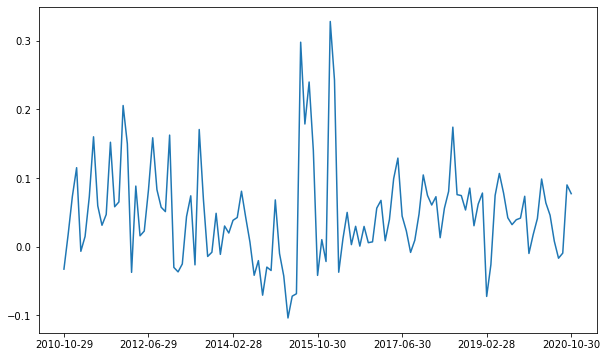

In [76]:
ARC_df.quantile().plot(figsize=(10, 6))

<AxesSubplot:>

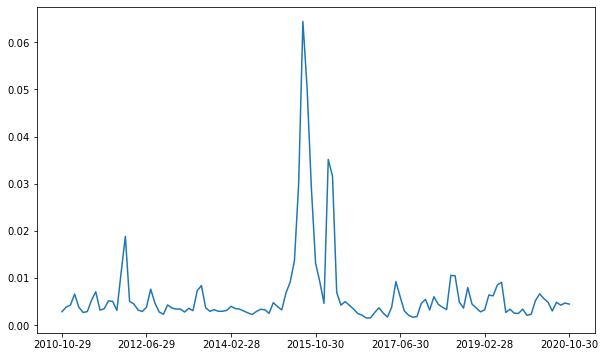

In [78]:
VRC_df.quantile().plot(figsize=(10, 6))